In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
from abc import ABCMeta

# import open bandit pipeline (obp)
from obp.dataset import OpenBanditDataset
from obp.dataset import linear_reward_function, logistic_reward_function
# from obp.dataset import SyntheticBanditDatasetWithActionEmbeds
from obp.policy import IPWLearner

from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
    SelfNormalizedDoublyRobust as SNDR
)

from my_utils import (
    NeighborhoodModel,
    eval_policy,
    # create_simluation_data_from_pi,
    # sample_policy_actions
)
random_state=12345
random_ = check_random_state(random_state)

In [2]:
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
def generate_dataset(params):
    emb_a = random_.normal(size=(params["n_actions"], params["emb_dim"]))
    noise_a = random_.normal(size=(params["emb_dim"]))
    our_a = (1-params["eps"]) * emb_a + params["eps"] * noise_a

    original_a = our_a.copy()

    emb_x = random_.normal(size=(params["n_users"], params["emb_dim"]))
    noise_x = random_.normal(size=(params["emb_dim"])) 
    our_x = (1-params["eps"]) * emb_x + params["eps"] * noise_x
    original_x = our_x.copy()

    score = emb_x @ emb_a.T
    score = random_.normal(score, scale=params["sigma"])
    q_x_a = (1 / (5.0 + np.exp(-score)))

    return dict(
                emb_a=emb_a,
                our_a=our_a,
                original_a=original_a,
                emb_x=emb_x,
                our_x=our_x,
                original_x=original_x,
                q_x_a=q_x_a,
                n_actions=params["n_actions"],
                n_users=params["n_users"],
                emb_dim=params["emb_dim"]
                )

In [36]:
def create_simluation_data_from_pi(pi: np.ndarray, q_x_a: np.ndarray, n_users: np.int, n_actions: np.int, random_state: int = 12345):
    random_ = check_random_state(random_state)
    simulation_data = {'actions':np.zeros((n_actions, n_users), dtype=np.int32), 
                       'users': np.zeros((n_actions, n_users), dtype=np.int32), 
                       'reward':np.zeros((n_actions, n_users)),
                       'pscore':np.zeros((n_actions, n_users))}
    
    reward = q_x_a  > random_.random(size=q_x_a.shape)
    simulation_data['pi_0'] = pi
    actions = []
    for i in range(n_users):
        user_actions = random_.choice(np.arange(n_actions), size=n_actions, p=pi[i], replace=False)
        actions.append(np.array(user_actions))

    actions = np.vstack(actions)
    for i in range(n_actions):
        simulation_data['actions'][i] = actions[:, i]
        simulation_data['users'][i] = np.arange(n_users)
        simulation_data['reward'][i] = np.squeeze(reward[np.arange(n_users), simulation_data['actions'][i]])
        simulation_data['pscore'][i] = np.squeeze(pi[np.arange(n_users), simulation_data['actions'][i]])
    
    simulation_data['q_x_a'] = reward
    return simulation_data

In [5]:
def get_test_data(dataset, simulation_data, n_test_data):
    return dict(
        num_data=n_test_data*dataset["n_users"],
        num_actions=dataset["n_actions"],
        x=dataset["our_x"][simulation_data['users'][:n_test_data].flatten()],
        a=simulation_data['actions'][:n_test_data].flatten(),
        r=simulation_data['reward'][:n_test_data].flatten(),
        x_idx=simulation_data['users'][:n_test_data].flatten(),
        pi_0=simulation_data['pi_0'],
        pscore=simulation_data['pscore'][:n_test_data].flatten(),
        q_x_a=simulation_data['q_x_a'],
    )

In [6]:
def get_train_data(n_actions, train_size, sim_data, idx, emb_x):
   return dict(
                num_data=train_size,
                num_actions=n_actions,
                x=emb_x[sim_data['users'][idx].flatten()],
                a=sim_data['actions'][idx].flatten(),
                r=sim_data['reward'][idx].flatten(),
                x_idx=sim_data['users'][idx].flatten(),
                pi_0=sim_data['pi_0'],
                pscore=sim_data['pscore'][idx].flatten(),
                q_x_a=sim_data['q_x_a']
                )

In [7]:
n_test_data = 5

dataset_params = dict(
                    n_actions= 150,
                    n_users = 150,
                    emb_dim = 5,
                    sigma = 0.1,
                    eps = 0.4
                    )

dataset = generate_dataset(dataset_params)

# num_rounds_list = [3, 6, 10, 15, 20]
num_rounds_list = [15, 20]
# num_rounds_list = [3, 6]

num_runs = 5 # number of simulations
max_iter = 25 # number of epochs

In [8]:
class CFModel(nn.Module):
    def __init__(self, num_users, num_actions, embedding_dim, 
                 initial_user_embeddings=None, initial_actions_embeddings=None):

        super(CFModel, self).__init__()
        self.num_actions = num_actions
        self.num_users = num_users

        
        # Initialize user and actions embeddings
        if initial_user_embeddings is None:
            self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        else:
            # If initial embeddings are provided, set them as the embeddings
            self.user_embeddings = nn.Embedding.from_pretrained(initial_user_embeddings, freeze=False)
        
        if initial_actions_embeddings is None:
            self.actions_embeddings = nn.Embedding(num_actions, embedding_dim)
        else:
            # If initial embeddings are provided, set them as the embeddings
            self.actions_embeddings = nn.Embedding.from_pretrained(initial_actions_embeddings, freeze=False)

    def get_params(self):
        return self.actions_embeddings(torch.arange(self.num_actions)), self.user_embeddings(torch.arange(self.num_users))
        
    def forward(self, user_ids):
        # Get embeddings for users and actions
        user_embedding = self.user_embeddings(user_ids)
        actions_embedding = self.actions_embeddings
        
        # Calculate dot product between user and actions embeddings
        scores = user_embedding @ actions_embedding(torch.arange(self.num_actions)).T
        
        # Apply softmax to get the predicted probability distribution
        return F.softmax(scores, dim=1).unsqueeze(-1)

In [33]:
class CustomCFDataset(Dataset):
    def __init__(self, user_idx, action_idx, rewards, original_prob):
        """
        Args:
            np_arrays (list of np.ndarray): List of numpy arrays
        """
        self.user_idx = user_idx
        self.action_idx = action_idx
        self.rewards = rewards
        self.original_prob = original_prob

    def __len__(self):
        return len(self.rewards)

    def __getitem__(self, sample_idx):   
        # Convert list to tensor
        if sample_idx in np.arange(len(self.rewards)):
            user = torch.tensor(self.user_idx[sample_idx].squeeze())
            action =  torch.tensor(self.action_idx[sample_idx].squeeze())
            reward = torch.tensor(self.rewards[sample_idx].squeeze(), dtype=torch.double)
            action_dist = torch.tensor(self.original_prob[user].squeeze())
            
            return user, action, reward, action_dist
        
        user = torch.tensor(self.user_idx[0].squeeze())
        action =  torch.tensor(self.action_idx[0].squeeze())
        reward = torch.tensor(self.rewards[0].squeeze(), dtype=torch.double)
        action_dist = torch.tensor(self.original_prob[user].squeeze())
        
        return user, action, reward, action_dist

In [10]:
class PolicyLoss(nn.Module):
    def __init__(self, log_eps=1e-10):
        super(PolicyLoss, self).__init__()
        self.log_eps = log_eps

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):
        n = original_policy_actions.shape[0]

        # q_hat_at_position = scores[torch.arange(n), :]
        # q_hat_factual = scores[torch.arange(n), original_policy_actions].squeeze()

        pi_e_at_position = policy_prob[torch.arange(n), original_policy_actions].squeeze()
        # log_pi = torch.log(pscore + self.log_eps).squeeze()
        iw = pi_e_at_position / pscore
        log_pi = torch.log(pi_e_at_position).squeeze()
        
        # DM
        # estimated_rewards_DM = (q_hat_at_position * pi_e_at_position).sum(axis=1).squeeze()

        # DR + IPS / NORM
        # ips_reward_grad = ((iw @ (original_policy_rewards - q_hat_factual.squeeze())) * log_pi) / iw.mean()

        # estimated_rewards =  ips_reward_grad + estimated_rewards_DM

        # reinforce trick step
        reinforce_grad = iw * original_policy_rewards * log_pi
        
        # r_hat_ipw = (iw * (original_policy_rewards - q_hat_factual))/ iw.mean()
        # r_hat = r_hat_ipw + estimated_rewards_DM
        
        # reinforce_grad = r_hat * log_pi
        
        return -reinforce_grad.mean()


In [11]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_09:00.csv


## OPE

In [ ]:
def no_learning_trial(
                      num_runs, 
                      num_neighbors, 
                      num_rounds_list, 
                      dataset
                      ):
    results = {}
    dm = DM()
    our_x, our_a, n_actions = dataset["our_x"], dataset["our_a"], dataset["n_actions"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):
            
            pi_0 = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            original_policy_prob = np.expand_dims(pi_0, -1)
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            
            regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())
            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))


        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = dict(
                                policy_rewards=np.mean(conv_results[: ,0]),
                                ipw=np.mean(conv_results[: ,3]),
                                reg_dm=np.mean(reg_results),
                                conv_dm=np.mean(conv_results[: ,1]), 
                                conv_dr=np.mean(conv_results[: ,2]),
                                conv_sndr=np.mean(conv_results[: ,4]),
                            )
        
    return pd.DataFrame.from_dict(results, orient='index')

In [13]:
# dm = DM()
# results = {}
num_runs = 15
batch_size = 50
num_neighbors = 5

#### Initial Noised Policy

In [39]:
df1 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, dataset)

In [40]:
df1

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
15,0.2000,0.1784,0.1458,0.1721,0.1758,0.1757
20,0.2089,0.1857,0.1437,0.1734,0.1816,0.1816


#### Optimal policy

In [41]:
temp_data = dataset.copy()
temp_data['our_a'] = dataset["emb_a"]
temp_data['our_x'] = dataset["emb_x"]

In [42]:
df2 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [43]:
df2

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
15,0.2124,0.2034,0.1454,0.1887,0.2079,0.2088
20,0.2044,0.2047,0.1431,0.1913,0.2072,0.2066


#### Random Policy

In [44]:
new_x = random_.normal(size=(dataset_params["n_users"], dataset_params["emb_dim"]))
new_a = random_.normal(size=(dataset_params["n_actions"], dataset_params["emb_dim"]))

temp_data['our_a'] = new_a
temp_data['our_x'] = new_x

In [45]:
df3 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [46]:
df3

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
15,0.1373,0.1725,0.1456,0.1525,0.1635,0.1640
20,0.1276,0.1406,0.1433,0.1396,0.1435,0.1441


#### Iterative improvement

In [47]:
df_iterative_improvment = df3.copy()
df_iterative_improvment['noise level'] = 10

for i in range(1, 10):
    temp_data['our_a'] = ((10-i) * new_a + i * dataset["emb_a"]) /10
    temp_data['our_x'] = ((10-i) * new_x + i * dataset["emb_x"]) /10

    rounds = [num_rounds_list[-1]]
    df = no_learning_trial(num_runs, num_neighbors, rounds, temp_data)
    df['noise level'] = 10 - i
    df_iterative_improvment = pd.concat([df_iterative_improvment, df])

In [58]:
df_iterative_improvment.iloc[1:][['noise level', 'policy_rewards', 'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr']]

,noise level,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
20,10,0.1276,0.1406,0.1433,0.1396,0.1435,0.1441
20,9,0.1316,0.1398,0.1433,0.1404,0.1412,0.1414
20,8,0.1458,0.1417,0.1433,0.1425,0.1421,0.1422
20,7,0.1404,0.1465,0.1433,0.1461,0.1458,0.1458
20,6,0.1640,0.1537,0.1433,0.1507,0.1513,0.1514
20,5,0.1880,0.1623,0.1432,0.1581,0.1611,0.1611
20,4,0.1898,0.1713,0.1432,0.1659,0.1724,0.1724
20,3,0.1924,0.1803,0.1432,0.1742,0.1789,0.1790
20,2,0.1960,0.1895,0.1432,0.1818,0.1875,0.1874
20,1,0.2058,0.1979,0.1431,0.1868,0.1978,0.1975


Bigger Dataset

In [49]:
n_test_data = 5

new_dataset_params = dict(
                    n_actions= 300,
                    n_users = 300,
                    emb_dim = 5,
                    sigma = 0.1,
                    eps = 0.4
                    )

new_dataset = generate_dataset(new_dataset_params)

num_rounds_list = [3, 6, 10, 15, 20]
num_runs = 2 # number of simulations
max_iter = 25 # number of epochs

In [50]:
no_learning_trial(num_runs, num_neighbors, rounds, new_dataset)

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
20,0.2333,0.1796,0.1425,0.1708,0.1794,0.1794


## Learning

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [15]:
# num_runs = 3
num_runs = 1

In [26]:
# 4. Define the training function
def train(model, train_loader, neighborhood_model, num_epochs=1, lr=0.0001):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) # here we can change the learning rate
    criterion = PolicyLoss()

    model.train() # Set the model to training mode
    tq = tqdm(range(num_epochs))
    for epoch in tq:
        running_loss = 0.0
        total_samples = 0
        
        for user_idx, action_idx, rewards, original_prob in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                user_idx = user_idx.to(device) 
                action_idx = action_idx.to(device)
                rewards = rewards.to(device)
                original_prob = original_prob.to(device) 
            
            # Forward pass
            policy = model(user_idx)
            pscore = original_prob[torch.arange(user_idx.shape[0]), action_idx.type(torch.long)]
            
            scores = torch.tensor(neighborhood_model.predict(user_idx))
            
            loss = criterion(
                              pscore,
                              scores,
                              policy, 
                              rewards, 
                              action_idx.type(torch.long), 
                              )
            
            # Zero the gradients Backward pass and optimization
            optimizer.zero_grad()

            loss.backward()       
            optimizer.step()
            
            # update neighborhood
            action_emb, context_emb = model.get_params()
            
            # Calculate running loss and accuracy
            running_loss += loss.item()
            total_samples += 1

            # Print statistics after each epoch
            epoch_loss = running_loss / total_samples
            tq.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
            
        neighborhood_model.update(action_emb.detach().numpy(), context_emb.detach().numpy())


In [ ]:
def trainer_trial(
                  num_runs,
                  num_neighbors,
                  num_rounds_list,
                  dataset,
                  batch_size,
                  num_epochs,
                  lr=0.001
                  ):
    dm = DM()
    results = {}

    our_x, our_a = dataset["our_x"], dataset["our_a"]
    emb_x, emb_a = dataset["emb_x"], dataset["emb_a"]
    
    original_x, original_a = dataset["original_x"], dataset["original_a"]
    n_users, n_actions, emb_dim = dataset["n_users"], dataset["n_actions"], dataset["emb_dim"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):

            pi_0 = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            original_policy_prob = np.expand_dims(pi_0, -1)
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            regression_model.fit(train_data['x'], 
                        train_data['a'],
                        train_data['r'],
                        original_policy_prob[train_data['x_idx'],
                        train_data['a']].squeeze()
                        )

            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            

            model = CFModel(
                            n_users, 
                            n_actions, 
                            emb_dim, 
                            initial_user_embeddings=torch.tensor(our_x), 
                            initial_actions_embeddings=torch.tensor(our_a)
                            )
            
            dataset =  CustomCFDataset(
                                       train_data['x_idx'], 
                                       train_data['a'], 
                                       train_data['r'], 
                                       original_policy_prob[train_data['x_idx']]
                                       )
            
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            
            train(model, train_loader, neighberhoodmodel, num_epochs=num_epochs, lr=lr)

            our_a, our_x = model.get_params()
            our_a, our_x = our_a.detach().numpy(), our_x.detach().numpy()

            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))

            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_a-our_a)), np.mean(np.abs(original_a-our_a))])
            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_x-our_x)), np.mean(np.abs(original_x-our_x))])
            
            our_a, our_x = original_a.copy(), original_x.copy()

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = dict(
                                    policy_rewards=np.mean(conv_results[: ,0]),
                                    ipw=np.mean(conv_results[: ,3]),
                                    reg_dm=np.mean(reg_results),
                                    conv_dm=np.mean(conv_results[: ,1]), 
                                    conv_dr=np.mean(conv_results[: ,2]),
                                    conv_sndr=np.mean(conv_results[: ,4]),
                                    action_diff_to_real=np.mean(conv_results[: ,5]),
                                    action_delta=np.mean(conv_results[: ,6]),
                                    context_diff_to_real=np.mean(conv_results[: ,7]),
                                    context_delta=np.mean(conv_results[: ,8])
                                    )
    
    return pd.DataFrame.from_dict(results, orient='index')

Regular Reinforce grad (iw * log_p * R)

In [37]:
df4 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size+100, num_epochs=1, lr=0.005)

Epoch [1/1], Loss: 0.7502: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
df4

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.1867,0.1471,0.1130,0.1152,0.1563,0.1590,0.3591,0.0109,0.6052,0.0021
6,0.1933,0.1462,0.1288,0.1275,0.1548,0.1567,0.3591,0.0185,0.6058,0.0048
10,0.1933,0.1456,0.1357,0.1399,0.1576,0.1589,0.3580,0.0267,0.6068,0.0097
15,0.2000,0.1460,0.1401,0.1427,0.1549,0.1558,0.3578,0.0312,0.6069,0.0138
20,0.2267,0.1465,0.1465,0.1508,0.1596,0.1602,0.3548,0.0360,0.6071,0.0183


Less epochs, different lr

In [ ]:
df5 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size+100, num_epochs=5, lr=0.001)

Epoch [5/5], Loss: 0.6819: 100%|██████████| 5/5 [11:16<00:00, 135.31s/it]


In [ ]:
df5

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.1933,0.1468,0.1130,0.1143,0.1554,0.1582,0.3592,0.0111,0.6053,0.0026
6,0.1933,0.1455,0.1288,0.1263,0.1561,0.1581,0.3585,0.0168,0.6059,0.0062
10,0.1933,0.1448,0.1357,0.1378,0.1552,0.1564,0.3578,0.0218,0.6070,0.0111
15,0.2133,0.1466,0.1401,0.1410,0.1545,0.1554,0.3569,0.0242,0.6074,0.0153
20,0.2133,0.1470,0.1465,0.1491,0.1612,0.1620,0.3554,0.0262,0.6077,0.0184


In [ ]:
df6 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size+100, num_epochs=10, lr=0.003)

Epoch [10/10], Loss: 0.3802: 100%|██████████| 10/10 [02:43<00:00, 16.36s/it]


In [ ]:
df6

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.2067,0.1410,0.1126,0.0978,0.1510,0.1555,0.3555,0.0674,0.6076,0.0157
6,0.1867,0.1335,0.1274,0.0981,0.1436,0.1481,0.3575,0.0993,0.6131,0.0368
10,0.2000,0.1308,0.1344,0.0978,0.1354,0.1391,0.3596,0.1253,0.6220,0.0647
15,0.1933,0.1408,0.1398,0.0926,0.1418,0.1458,0.3609,0.1405,0.6298,0.0886
20,0.2067,0.1465,0.1468,0.0942,0.1588,0.1614,0.3585,0.1499,0.6368,0.1086


In [ ]:
df7 = trainer_trial(num_runs, num_neighbors, num_rounds_list[:-3], dataset, batch_size+100, num_epochs=10, lr=0.003)

0.13069560060859173


Epoch [10/10], Loss: 0.5961: 100%|██████████| 10/10 [04:25<00:00, 26.57s/it]


0.1316379049999357


Epoch [10/10], Loss: 0.5186: 100%|██████████| 10/10 [26:42<00:00, 160.28s/it]


MemoryError: Unable to allocate 6.03 GiB for an array with shape (450000, 1800) and data type float64

In [ ]:
df7

NameError: name 'df6' is not defined

In [ ]:
# # original_policy_prob = np.expand_dims(softmax(original_x @ original_a.T, axis=1), -1)
# original_policy_prob = np.expand_dims(np.ones_like(q_x_a) / (n_actions), -1)
# dm = DM()
# results = {}
# num_runs = 1
# batch_size = 50
# num_neighbors = 4

# for train_size in num_rounds_list:
#     reg_results, conv_results = [], []
#     for run in range(num_runs):

#         idx = np.arange(train_size) + n_test_data
#         train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x, q_x_a)
        
#         regression_model = RegressionModel(
#                                             n_actions=n_actions,
#                                             action_context=emb_x,
#                                             base_model=LogisticRegression(random_state=12345)
#                                             )
        
#         neighberhoodmodel = NeighborhoodModel(
#                                                 train_data['x_idx'],
#                                                 train_data['a'], 
#                                                 our_a,
#                                                 our_x, 
#                                                 train_data['r'], 
#                                                 num_neighbors=num_neighbors
#                                             )
        
#         regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())

#         # model = CFModel(n_users, n_actions, emb_dim, initial_user_embeddings=torch.tensor(our_x), initial_actions_embeddings=torch.tensor(our_a))
#         # dataset =  CustomCFDataset(train_data['x_idx'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx']])
#         # train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#         # adam = optim.Adam(model.parameters())
#         # loss_fn = PolicyLoss()
        
#         # train(model, train_loader, loss_fn, adam, neighberhoodmodel)

#         # our_a, our_x = model.get_params()
#         # our_a, our_x = our_a.detach().numpy(), our_x.detach().numpy()

#         # print(np.mean(np.abs(emb_a-our_a)))
#         # print(np.mean(np.abs(original_a-our_a)))

#         policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

#         reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
#         reg_results.append(reg_dm)

#         conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
        
#         # conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_a-our_a)), np.mean(np.abs(original_a-our_a))])
#         # our_a, our_x = original_a.copy(), original_x.copy()

#     reg_results = np.array(reg_results)
#     conv_results = np.array(conv_results)

#     results[train_size] = dict(
#                                 # reg_rewards=np.mean(reg_results[: ,0]),
#                                 # reg_dm=np.mean(reg_results[: ,1]), 
#                                 # reg_dr=np.mean(reg_results[: ,2]),
#                                 # reg_ipw=np.mean(reg_results[: ,3]),
#                                 # reg_sndr=np.mean(reg_results[: ,4]),
#                                 # reg_var_dm=np.std(reg_results[: ,1] - reg_results[: ,0]),
#                                 # reg_var_dr=np.std(reg_results[: ,2] - reg_results[: ,0]),
#                                 # reg_var_ipw=np.std(reg_results[: ,3] - reg_results[: ,0]),
#                                 # reg_var_sndr=np.std(reg_results[: ,4] - reg_results[: ,0]),
#                                 policy_rewards=np.mean(conv_results[: ,0]),
#                                 ipw=np.mean(conv_results[: ,3]),
#                                 reg_dm=np.mean(reg_results),

#                                 conv_dm=np.mean(conv_results[: ,1]), 
#                                 conv_dr=np.mean(conv_results[: ,2]),
#                                 conv_sndr=np.mean(conv_results[: ,4]),
#                                 # diff_to_real=np.mean(conv_results[: ,5]),
#                                 # diff_from_start=np.mean(conv_results[: ,6])
#                                 # conv_var_dm=np.std(conv_results[: ,1] - conv_results[: ,0]),
#                                 # conv_var_dr=np.std(conv_results[: ,2] - conv_results[: ,0]),
#                                 # conv_var_ipw=np.std(conv_results[: ,3] - conv_results[: ,0]),
#                                 # conv_var_sndr=np.std(conv_results[: ,4] - conv_results[: ,0]),
#                             )

In [ ]:
df = pd.DataFrame.from_dict(results, orient='index')

NameError: name 'results' is not defined

In [ ]:
df

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr
3,0.56,0.199051,0.149066,0.153500,0.209685,0.209908
6,0.56,0.199051,0.152306,0.164966,0.199016,0.199152
10,0.56,0.199051,0.159112,0.173460,0.198981,0.199082
15,0.56,0.199051,0.145156,0.159052,0.200623,0.200788
20,0.56,0.199051,0.144494,0.158721,0.191275,0.191405


In [ ]:
df['getting closer to real emb'] = df['diff_to_real'].max() - df['diff_to_real']

KeyError: 'diff_to_real'

<Axes: >

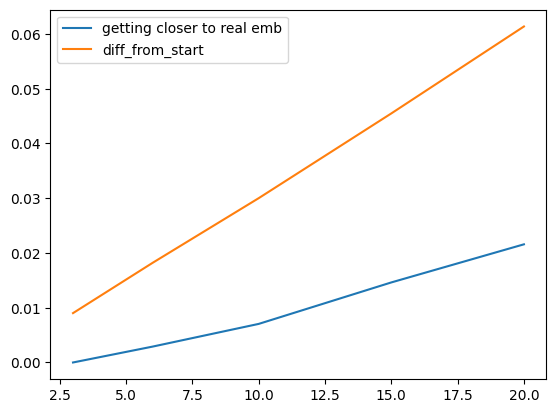

In [ ]:
df.plot(y=['getting closer to real emb', 'diff_from_start'])